# Dominik Szot, 16.03.2023
## Laboratorium 02 
## Metoda najmniejszych kwadratów

Pierwszym krokiem w celu rozwiązania problemu będzie import potrzebnych bibliotek, oraz zaczytanie zbiorów danych

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as scp

with open("breast-cancer.labels","r") as f:
    labels = [line.rstrip() for line in f]
    
train_data= pd.read_csv('breast-cancer-train.dat', names=labels)
validate_data= pd.read_csv('breast-cancer-validate.dat', names=labels)


Histogram przedstawiający rozkład średniej wartości "radius", oraz wykres średniej wartości "area" w zależności od i-tej badanej osoby

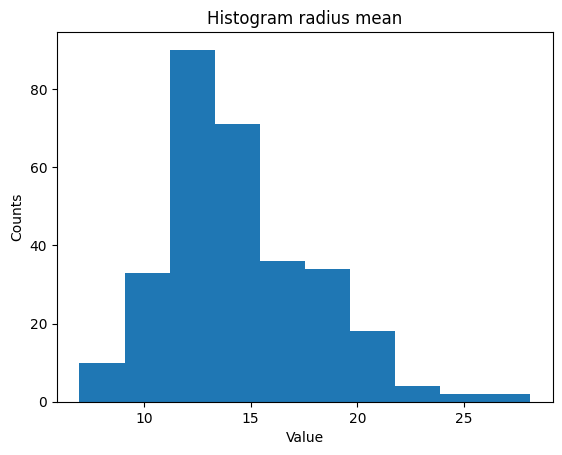

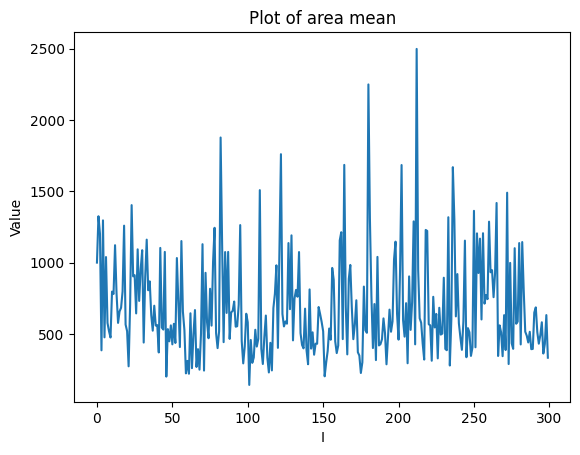

In [98]:
radius_mean = train_data['radius (mean)']
area_mean = train_data['area (mean)']

fig, plot = plt.subplots(1, 1)

plt.hist(radius_mean)
plot.set_title("Histogram radius mean")
plot.set_xlabel("Value")
plot.set_ylabel("Counts")
plt.show()

plt.plot(area_mean)
plt.title("Plot of area mean")
plt.xlabel("I")
plt.ylabel("Value")
plt.show()

Tworzenie reprezentacji danych ze zbiorów dla liniowej i kwadratowej macierzy.  
$$A_{lin} = \begin{bmatrix} f_{1,1} & f_{1,2} & f_{1,3} & f_{1,4} \\f_{2,1} & f_{2,2} & f_{2,3} & f_{2,4} \\ ... & ... & ... & ... \\ f_{n,1} & f_{n,2} & f_{n,3} & f_{n,4} \end{bmatrix}$$


$$A_{quad} = \begin{bmatrix} f_{1,1} & f_{1,2} & f_{1,3} & f_{1,4} & f_{1,1}^2 & f_{1,2}^2 & f_{1,3}^2 & f_{1,4}^2 & f_{1,1}f_{1,2} & f_{1,1}f_{1,3} & f_{1,1}f_{1,4} & f_{1,2}f_{1,3} & f_{1,2}f_{1,4} & f_{1,3}f_{1,4} \\ ...  \\ f_{n,1} & f_{n,2} & f_{n,3} & f_{n,4} & f_{n,1}^2 & f_{n,2}^2 & f_{n,3}^2 & f_{n,4}^2 & f_{n,1}f_{n,2} & f_{n,1}f_{n,3} & f_{n,1}f_{n,4} & f_{n,2}f_{n,3} & f_{n,2}f_{n,4} & f_{n,3}f_{n,4} \end{bmatrix}$$

In [99]:
def quadric_representation(data):
    A_quadratic_representation = np.zeros((len(data), 14))
    
    for i in range(len(A_quadratic_representation)):
        for j in range(4):
            A_quadratic_representation[i][j] = data[i][j]
        for j in range(4, 8):
            A_quadratic_representation[i][j] = data[i][j-4]**2
        x = 0
        for m in range(6):
            for n in range(m+1, 4):
                A_quadratic_representation[i][8+x] = data[i][m] * data[i][n]
                x+=1
    
    return A_quadratic_representation


In [104]:
A_linear_train = np.array(train_data.iloc[:, 2:len(train_data.columns)].values)

train_quadratic_data = train_data.loc[:, ["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]].values
A_train_quadratic_representation = np.array(quadric_representation(train_quadratic_data))

A_linear_validate = np.array(validate_data.iloc[:, 2:len(validate_data.columns)].values)
validate_quadratic_data = validate_data.loc[:, ["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]].values
A_validate_quadratic_representation = np.array(quadric_representation(validate_quadratic_data))

Dla obu zbiorów tworzymy wektor b

In [105]:
train_b = train_data.loc[:,["Malignant/Benign"]].values

for i in range(len(train_b)):
       train_b[i] = 1. if (train_b[i][0] == 'M') else -1.
       

validate_b = validate_data.loc[:,["Malignant/Benign"]].values

for i in range(len(validate_b)):
       validate_b[i] = 1. if (validate_b[i][0] == 'M') else -1.


W celu obliczenia wagi dla liniowej i kwadratowej reprezentacji najmniejszyk kwadratów dla zbioru ```breast-cancer-train``` skorzystam z własności 
$$ w = (A^TA)^{-1}A^Tb $$

Aby obliczyć ```współczynnik uwarunkowania``` posłużę się z kolei wzorem 
$$ cond(A) = ||A|| * ||A^{-1}|| $$


In [106]:
AT = np.transpose(A_linear_train)
ATA = np.linalg.inv(np.dot(AT, A_linear_train))
w = np.dot(np.dot(ATA, AT), train_b)

BT = np.transpose(A_train_quadratic_representation)
BTB = np.linalg.inv(np.dot(BT, A_train_quadratic_representation))
w2 = np.dot(np.dot(BTB, BT), train_b)

In [109]:
cond_linear = np.dot(np.linalg.norm(A_linear_train), np.linalg.norm(np.linalg.pinv(A_linear_train)))
cond_quadric = np.dot(np.linalg.norm(A_train_quadratic_representation), np.linalg.norm(np.linalg.pinv(A_train_quadratic_representation)))

print(cond_linear, cond_quadric)

1963526.5116154004 1058220805.6518416


Aby sprawdzić jak otrzymane wagi przewiduja typ nowotworu mnożę liniową reprezentację zbioru ```breast-cancer-validate.dat``` oraz wyliczony wektor wag w orzymując wektor p.
Zgodnie z założeniami zadania zakładamy że i-ta osoba ma nowotwór złośliwy jeśli wartość ```p[i]``` jest większa od 0. 

Następnie porównuję otrzymane wyniki z wynikami rzeczywistymi

* Nasza reprezentacja wskazała dla reprezentacji liniowej ```6``` wyników fałszywie pozytwynych a ```2``` wyniki fałszywie negatywne
* Dla reprezentacji kwadratowej było to już ```15``` wyników fałszywie pozytwynych oraz  ```5``` wyników fałszywie negatywnych

Bardziej skuteczną reprezentacja danych okazała się reprezentacja liniowa, która osiągnęła skutecznosć na poziomie ```96.92% ```
Potwierdza to również wynik obliczeń wskaźnika uwarukowania, który był bardziej korzystniejszy dla reprezentacji liniowej

In [119]:
p = np.dot(A_linear_validate,w)
p2 = np.dot(A_validate_quadratic_representation,w2)

for i in range(len(p)):
    p[i] = 1. if p[i] > 0 else -1

for i in range(len(p2)):
    p2[i] = 1. if p2[i] > 0 else -1

false_positives = 0 
false_negatives = 0

false_positives_q = 0 
false_negatives_q = 0

solution = validate_data.loc[:, ["Malignant/Benign"]].values

for i in range(len(solution)):
    solution[i] = 1. if (solution[i][0] == 'M') else -1.

for i in range(len(p)):
    if solution[i] == -1 and p[i] == 1:
        false_positives += 1
    if solution[i] == 1 and p[i] == -1:
        false_negatives += 1
    if solution[i] == -1 and p2[i] == 1:
        false_positives_q += 1
    if solution[i] == 1 and p2[i] == -1:
        false_negatives_q += 1

efficiency1 = (len(p) - (false_positives+false_negatives))/len(p)*100    
efficiency2 = (len(p) - (false_positives_q+false_negatives_q))/len(p)*100        
        
print(f'false-positives: {false_positives}')
print(f'false-negatives: {false_negatives}')

print(f'false-positives-q: {false_positives_q}')
print(f'false-negatives-q: {false_negatives_q}')

print(f'Skutecznosć {efficiency1:.2f}% dla reprezentacji liniowej, {efficiency2:.2f}% dla reprezentacji kwadratowej')


false-positives: 6
false-negatives: 2
false-positives-q: 15
false-negatives-q: 5
Skutecznosć 96.92% dla reprezentacji liniowej, 92.31% dla reprezentacji kwadratowej


Bibliografia 
* Katarzyna Rycerz: Wykład z przedmiotu Metody Obliczeniowe w Nauce i Technice
* Marcin Kuta: Materiały z zajęć - Least squares method